In [5]:
%autosave 100

Autosaving every 100 seconds


In [2]:
import numpy as np
import numpy.linalg as npl
import math
import numdifftools as nd
import matplotlib.pyplot as plt

In [3]:
DELTA = 0.01
P_g = dict([('AlCl', 0),('AlCl2', 0),('AlCl3', 0),('GaCl', 0),('GaCl2', 0),('GaCl3', 0),('H2', 0),('HCl', 10000),('N2', 90000)])
NAMES = ['AlCl', 'AlCl2', 'AlCl3', 'GaCl', 'GaCl2', 'GaCl3', 'NH3', 'H2', 'HCl', 'N2', 'Al', 'Ga', 'AlN', 'GaN']
R = 8.314
KELVIN = 273

h   = dict(zip(NAMES, [-51032., -259000., -584100., -70553., -241238., -431573., -45940., 0., -92310., 0., 0., 0., -319000., -114000.]))
fi1 = dict(zip(NAMES, [318.9948, 427.2137, 511.8114, 332.2718, 443.2976, 526.8113, 231.1183, 205.5368, 243.9878, 242.8156, 172.8289, 125.9597, 123.1132, 160.2647]))
fi2 = dict(zip(NAMES, [36.94626, 56.56409, 81.15042, 37.11052, 57.745845, 82.03355, 20.52222, 29.50487, 23.15984, 21.47467, 50.51806, 26.03107, 44.98092, 52.86351]))
fi3 = dict(zip(NAMES, [-0.001226431, -0.002961273, -0.004834879, -0.000746187, -0.002265112, -0.003486473, 0.000716251, 0.000168424, 0.001819985, 0.001748786, -0.00411847, 0.001178297, -0.00734504, -0.00799055]))
fi4 = dict(zip(NAMES, [1.1881743, 1.893842, 2.752097, 1.1606512, 1.8755545, 2.6855923, 0.7677236, 0.86065612, 0.6147384, 0.5910039, 1.476107, 0.13976, 1.86107, 2.113389]))
fi5 = dict(zip(NAMES, [5.638541, 12.40072, 13.40078, 4.891346, 3.66186, 8.278878, 244.6296, -14.95312, 51.16604, 81.08497, -458.1279, -0.5698425, 31.39626, 1.313428]))
fi6 = dict(zip(NAMES, [-5.066135, -22.65441, -21.28001, -4.467591, -9.356338, -14.5678, -251.69, 78.18955, -36.89502, -103.6265, 2105.75, 0.04723008, -49.92139, -2.441129]))
fi7 = dict(zip(NAMES, [5.219347, 21.29898, 16.92868, 5.506236, 15.88245, 12.8899, 146.6947, -82.78981, 9.174252, 71.30775, -4168.337, 7.212525, 81.22038, 1.945731]))
mu  = dict(zip(NAMES, [62.4345, 97.8875, 133.3405, 105.173, 140.626, 176.080, 17.031, 2.016, 36.461, 28.0135, 26.9815, 69.723, 40.988, 83.730]))
sigma = dict(zip(['AlCl', 'AlCl2', 'AlCl3', 'GaCl', 'GaCl2', 'GaCl3', 'NH3', 'H2', 'HCl', 'N2'], [3.58, 5.3, 5.13, 3.696, 4.293, 5.034, 3.0, 2.93, 2.737, 3.798]))
eps   = dict(zip(['AlCl', 'AlCl2', 'AlCl3', 'GaCl', 'GaCl2', 'GaCl3', 'NH3', 'H2', 'HCl', 'N2'], [932., 825., 472., 348.2, 465., 548.24, 300., 34.1, 167.1, 71.4]))
ro = dict(zip(['Al', 'Ga', 'AlN', 'GaN'], [2690, 5900, 3200, 6150]))

In [8]:
def Hi(T):
    return T / math.pow(10, 4)

def Fi_elem(elem, T):
    return fi1[elem] + fi2[elem] * np.log(Hi(T)) + fi3[elem] / math.pow(Hi(T), 2) + fi4[elem] / Hi(T) + \
           fi5[elem] * Hi(T) + fi6[elem] * (Hi(T)**2) + fi7[elem] * (Hi(T)**3)                
def G_elem(elem, T):
    return h[elem] - Fi_elem(elem, T) * T

In [59]:
def K1(T):
    return math.exp((2 * G_elem('AlCl', T) + G_elem('H2', T) - 2 * G_elem('HCl', T) - 2 * G_elem('Al', T)) / (R * T)) / (10**5)
    
def K2(T):
    return math.exp((G_elem('AlCl2', T) + G_elem('H2', T) - 2 * G_elem('HCl', T) - G_elem('Al', T)) / (R * T))
    
def K3(T):
    return math.exp((2 * G_elem('AlCl3', T) + 3 * G_elem('H2', T) - 6 * G_elem('HCl', T) - 2 * G_elem('Al', T)) / (R * T)) * (10**5)

In [10]:
def Sigma_elemN2(elem):
    return (sigma[elem] + sigma['N2']) / 2

def Eps_elemN2(elem):
    return (eps[elem] * eps['N2'])**(1/2)

def Mu_elemN2(elem):
    return 2 * mu[elem] * mu['N2'] / (mu[elem] + mu['N2'])

def Sigma1_1(x):
    return 1.074 * (x ** (-0.1604))

def D_elem(elem, T):
    return 0.02628 * (T**(3/2)) / ((10**5) * Sigma_elemN2(elem) * Sigma1_1(T / Eps_elemN2(elem)) * (Mu_elemN2(elem)**(1/2)))

In [11]:
def f0_1(x, T):
    return (x[0]**2) - K1(T) * x[1] * (x[2]**2)

def f1_1(x, T):
    return (x[0]**2) - K2(T)  * x[1] * x[3]

def f2_1(x, T):
    return (x[0]**6) - K3(T)  * (x[1]**3) * (x[4]**2)

def f3_1(x, T):
    return x[0] + 2 * D_elem('H2', T) / D_elem('HCl', T) * x[1] - (10**4)

def f4_1(x, T):
    return x[0] + D_elem('AlCl', T) / D_elem('HCl', T) * x[2] + 2 * D_elem('AlCl2', T) / D_elem('HCl', T) * x[3] + \
           3 * D_elem('AlCl3', T) / D_elem('HCl', T) * x[4] - (10**4)

def f_1(x, T):
    return np.array([f0_1(x, T), f1_1(x, T), f2_1(x, T), f3_1(x, T), f4_1(x, T)])

In [5]:
def newton(f, params, eps=1e-6, max_iter=int(1e6), init=[1] * 5):
#     x_ = np.array([1, 1, 1, 1, 1])
    x_ = np.array(init)
    norm = 1
    iters = 0
    while norm > eps and iters < max_iter:
        a = nd.Jacobian(f)
        b = a(x_, *params)
        c = npl.inv(b)
        x = x_ - c @ f(x_, *params)
        norm = npl.norm(x - x_)
        x_ = x
        iters += 1
    
#     if (iters >= max_iter):
#         print('Превышено максимальное число итераций. Текущая норма:', norm)
#     else:
#         print('Итераций:', iters)
#     print('Проверка f(x, T) = 0 :', np.allclose(f(x, *params), [0] * len(init)))
    return x

In [25]:
def G(elem, P_e, T, P_g=P_g):
    return D_elem(elem, T) * (P_g[elem] - P_e[elem]) / (8314 * T * DELTA)

def V_al(P_e, T):
    return (G('AlCl', P_e, T) + G('AlCl2', P_e, T) + G('AlCl3', P_e, T)) * (mu['Al'] / ro['Al']) * (10**9)

def V_ga(P_e, T):
    return (G('GaCl', P_e, T) + G('GaCl2', P_e, T) + G('GaCl3', P_e, T)) * (mu['Ga'] / ro['Ga']) * (10**9)

#P_e = dict(zip(['HCl', 'H2', 'AlCl', 'AlCl2', 'AlCl3'], newton(f, 800)))
#print(G('AlCl', P_e, 800))
#print(G('AlCl2', P_e, 800))
#print(G('AlCl3', P_e, 800))
#print(V_al(P_e, 800))

Итераций: 49
Проверка f(x, T) = 0 : True
Итераций: 43
Проверка f(x, T) = 0 : True
Итераций: 39
Проверка f(x, T) = 0 : True
Итераций: 34
Проверка f(x, T) = 0 : True
Итераций: 30
Проверка f(x, T) = 0 : True
Итераций: 28
Проверка f(x, T) = 0 : True
Итераций: 27
Проверка f(x, T) = 0 : True
Итераций: 27
Проверка f(x, T) = 0 : True
Итераций: 40
Проверка f(x, T) = 0 : True
Итераций: 52
Проверка f(x, T) = 0 : True


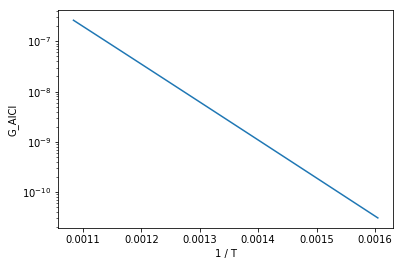

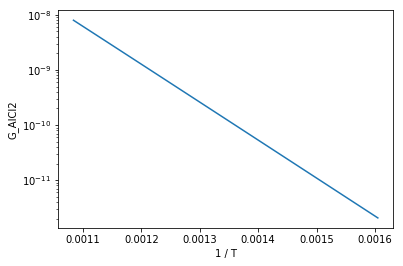

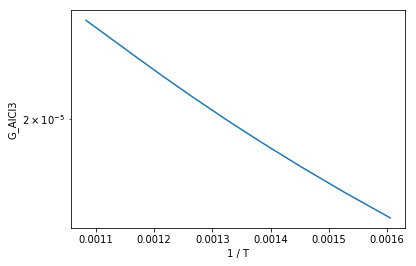

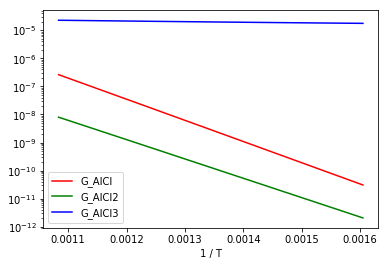

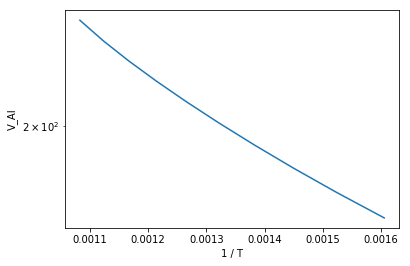

In [71]:
#===== Task 1 =====
STEPS = 10
x = np.linspace(350 + KELVIN, 650 + KELVIN, STEPS)
y = [dict(zip(['HCl', 'H2', 'AlCl', 'AlCl2', 'AlCl3'], newton(f_1, [t]))) for t in x]
y1 = np.fabs([G('AlCl', y[i], x[i]) for i in range(STEPS)])
y2 = np.fabs([G('AlCl2', y[i], x[i]) for i in range(STEPS)])
y3 = np.fabs([G('AlCl3', y[i], x[i]) for i in range(STEPS)])
y4 = np.fabs([V_al(y[i], x[i]) for i in range(STEPS)])

xs = np.divide(np.array([1 for i in range(STEPS)]), x)

plt.plot(xs, y1)
plt.xlabel('1 / T')
plt.ylabel('G_AlCl')
plt.yscale('log')
plt.show()

plt.plot(xs, y2)
plt.xlabel('1 / T')
plt.ylabel('G_AlCl2')
plt.yscale('log')
plt.show()

plt.plot(xs, y3)
plt.xlabel('1 / T')
plt.ylabel('G_AlCl3')
plt.yscale('log')
plt.show()

fig, ax = plt.subplots()
ax.plot(xs, y1, color='r', label='G_AlCl')
ax.plot(xs, y2, color='g', label='G_AlCl2')
ax.plot(xs, y3, color='b', label='G_AlCl3')
ax.set_xlabel('1 / T')
ax.set_yscale('log')
ax.legend()
plt.show()

plt.plot(xs, y4)
plt.xlabel('1 / T')
plt.ylabel('V_Al')
plt.yscale('log')
plt.show()

In [53]:
def K4(T):
    return math.exp((2 * G_elem('GaCl', T) + G_elem('H2', T) - 2 * G_elem('HCl', T) - 2 * G_elem('Ga', T)) / (R * T)) / (10**5)
    
def K5(T):
    return math.exp((G_elem('GaCl2', T) + G_elem('H2', T) - 2 * G_elem('HCl', T) - G_elem('Ga', T)) / (R * T))
    
def K6(T):
    return math.exp((2 * G_elem('GaCl3', T) + 3 * G_elem('H2', T) - 6 * G_elem('HCl', T) - 2 * G_elem('Ga', T)) / (R * T)) * (10**5)

In [51]:
def f0_2(x, T):
    return (x[0]**2) - K4(T) * x[1] * (x[2]**2)

def f1_2(x, T):
    return (x[0]**2) - K5(T)  * x[1] * x[3]

def f2_2(x, T):
    return (x[0]**6) - K6(T)  * (x[1]**3) * (x[4]**2)

def f3_2(x, T):
    return x[0] + 2 * D_elem('H2', T) / D_elem('HCl', T) * x[1] - (10**4)

def f4_2(x, T):
    return x[0] + D_elem('GaCl', T) / D_elem('HCl', T) * x[2] + 2 * D_elem('GaCl2', T) / D_elem('HCl', T) * x[3] + \
           3 * D_elem('GaCl3', T) / D_elem('HCl', T) * x[4] - (10**4)

def f_2(x, T):
    return np.array([f0_2(x, T), f1_2(x, T), f2_2(x, T), f3_2(x, T), f4_2(x, T)])

Итераций: 31
Проверка f(x, T) = 0 : True
Итераций: 21
Проверка f(x, T) = 0 : False
Итераций: 19
Проверка f(x, T) = 0 : False
Итераций: 16
Проверка f(x, T) = 0 : True
Итераций: 20
Проверка f(x, T) = 0 : True
Итераций: 21
Проверка f(x, T) = 0 : True
Итераций: 21
Проверка f(x, T) = 0 : False
Итераций: 22
Проверка f(x, T) = 0 : False
Итераций: 23
Проверка f(x, T) = 0 : False
Итераций: 24
Проверка f(x, T) = 0 : True


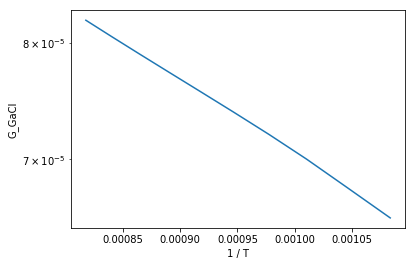

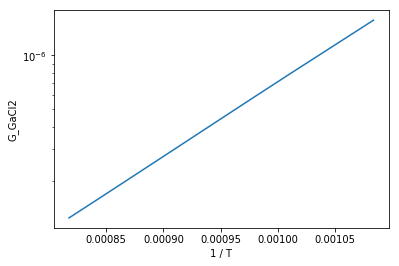

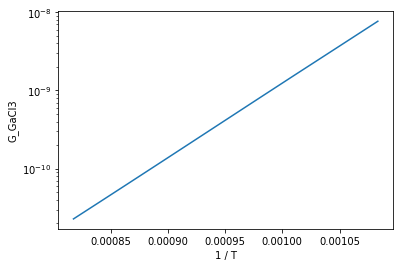

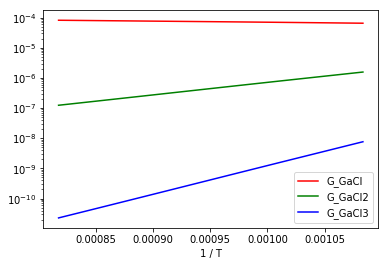

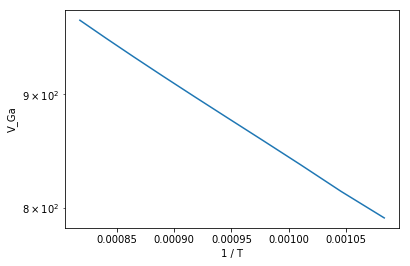

In [54]:
#===== Task 2 =====
STEPS = 10
x = np.linspace(650 + KELVIN, 950 + KELVIN, STEPS)
y = [dict(zip(['HCl', 'H2', 'GaCl', 'GaCl2', 'GaCl3'], newton(f_2, [t]))) for t in x]
y1 = np.fabs([G('GaCl', y[i], x[i]) for i in range(STEPS)])
y2 = np.fabs([G('GaCl2', y[i], x[i]) for i in range(STEPS)])
y3 = np.fabs([G('GaCl3', y[i], x[i]) for i in range(STEPS)])
y4 = np.fabs([V_ga(y[i], x[i]) for i in range(STEPS)])

xs = np.divide(np.array([1 for i in range(STEPS)]), x)

plt.plot(xs, y1)
plt.xlabel('1 / T')
plt.ylabel('G_GaCl')
plt.yscale('log')
plt.show()

plt.plot(xs, y2)
plt.xlabel('1 / T')
plt.ylabel('G_GaCl2')
plt.yscale('log')
plt.show()

plt.plot(xs, y3)
plt.xlabel('1 / T')
plt.ylabel('G_GaCl3')
plt.yscale('log')
plt.show()

fig, ax = plt.subplots()
ax.plot(xs, y1, color='r', label='G_GaCl')
ax.plot(xs, y2, color='g', label='G_GaCl2')
ax.plot(xs, y3, color='b', label='G_GaCl3')
ax.set_xlabel('1 / T')
ax.set_yscale('log')
ax.legend()
plt.show()

plt.plot(xs, y4)
plt.xlabel('1 / T')
plt.ylabel('V_Ga')
plt.yscale('log')
plt.show()

In [ ]:
# GaCl2 и GaCl3 на графиках растут и не очень понятно, насколько это правильно.
# В остальном все хорошо - преобладают AlCl3 и GaCl
#

In [27]:
#===== Task 3 =====
STEPS = 10
T = 1100 + KELVIN

P_ATM = 10 ** 5
def partial_pressures(al_factor, h_factor):
    return dict([
        ('HCl', 0)
        , ('AlCl3', al_factor * 30)
        , ('GaCl', (1 - al_factor) * 30)
        , ('NH3', 1500)
        , ('H2', h_factor * 98470)
        , ('N2', (1 - h_factor) * 98470)
    ])


def V_algan(G_al, G_ga):
    return (G_al * mu['AlN'] / ro['AlN'] + 
                 G_ga * mu['GaN'] / ro['GaN'])* 1e9

# AlCl3 + NH3 = AlN (s) + 3HCl
def K9(T):
    delta_g = G_elem('AlCl3', T) + G_elem('NH3', T) - G_elem('AlN', T) - 3 * G_elem('HCl', T)
    return math.exp(-delta_g / R / T) / P_ATM
    
# GaCl + NH3 = GaN (s) + HCl + H2
def K10(T):
    return math.exp((G_elem('GaN', T) + G_elem('HCl', T) + G_elem('H2', T)
                     - G_elem('GaCl', T) - G_elem('NH3', T)) / R / T)


vars = ['x', 'AlCl3', 'GaCl', 'NH3', 'HCl', 'H2']

def f3(x, al_factor, h_factor):
    index_dict = dict(zip(vars, range(6)))
    def from_var(v):
        return x[index_dict[v]]
    pp = partial_pressures(al_factor, h_factor)
    return np.array([
        from_var('AlCl3') * from_var('NH3') - K9(T) * from_var('x') * from_var('HCl') ** 3
        , from_var('GaCl') * from_var('NH3') - K10(T) * (1 - from_var('x')) * from_var('HCl') * from_var('H2')
        , D_elem('HCl', T) * (pp['HCl'] - from_var('HCl')) + 2 * D_elem('H2', T) * (pp['H2'] - from_var('H2')) + 3 * D_elem('NH3', T) * (pp['NH3'] - from_var('NH3'))
        , 3 * D_elem('AlCl3', T) * (pp['AlCl3'] - from_var('AlCl3')) + D_elem('GaCl', T) * (pp['GaCl'] - from_var('GaCl')) + D_elem('HCl', T) * (pp['HCl'] - from_var('HCl'))
        , D_elem('AlCl3', T) * (pp['AlCl3'] - from_var('AlCl3')) + D_elem('GaCl', T) * (pp['GaCl'] - from_var('GaCl')) - D_elem('NH3', T) * (pp['NH3'] - from_var('NH3'))
        , from_var('x') * D_elem('GaCl', T) * (pp['GaCl'] - from_var('GaCl')) - (1 - from_var('x')) * D_elem('AlCl3', T) * (pp['AlCl3'] - from_var('AlCl3'))
    ])

al_factors = np.linspace(0, 1, STEPS)
h_factors = [0, .1]
solutions = [[newton(f3, [al_factor, h_factor], init=[1] + [10 ** 4] * 5) for al_factor in al_factors] for h_factor in h_factors]

Случай  1


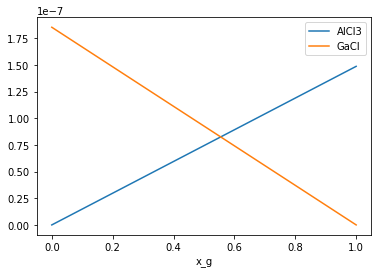

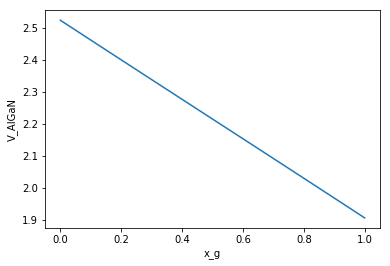

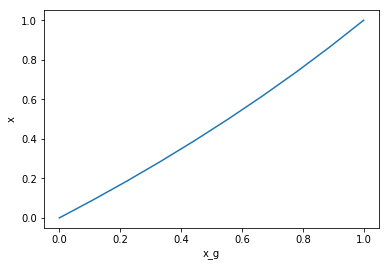

Случай  2


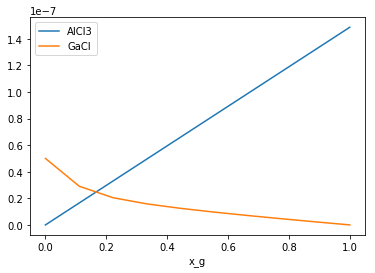

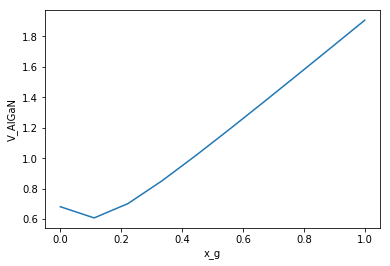

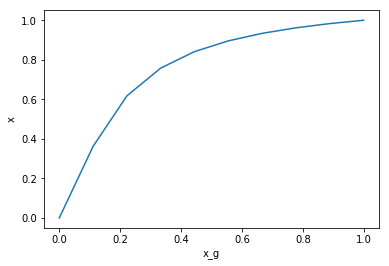

In [28]:
for i in range(2):
    print('Случай ', i + 1)
    solution = solutions[i]
    
    _, ax = plt.subplots()
    
    G_cl = dict([])
    for elem in ['AlCl3', 'GaCl']:
        G_cl[elem] = []
        for j in range(len(al_factors)):
            p_g = partial_pressures(al_factors[j], h_factors[i])
            p_e = dict(zip(vars, solution[j]))
            G_cl[elem].append(np.fabs(G(elem, p_e, T, P_g=p_g)))
        ax.plot(al_factors, G_cl[elem], label=elem)
    ax.set_xlabel('x_g')
    ax.legend()
    plt.show()
    
    vs = [np.fabs(V_algan(G_cl['AlCl3'][j], G_cl['GaCl'][j])) for j in range(len(al_factors))]
    plt.plot(al_factors, vs)
    plt.xlabel('x_g')
    plt.ylabel('V_AlGaN')
    plt.show()
    
    plt.plot(al_factors, [solution[j][0] for j in range(len(al_factors))])
    plt.xlabel('x_g')
    plt.ylabel('x')
    plt.show()